In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import glob
%matplotlib inline

# Camera calibration

In [2]:
from camera_calibrator import CameraCalibrator

In [3]:
calibration_images = glob.glob('camera_cal/calibration*.jpg')
camera_calibrator = CameraCalibrator(9, 6, images=calibration_images)
camera_calibrator.calibrate_camera()

Camera ready!


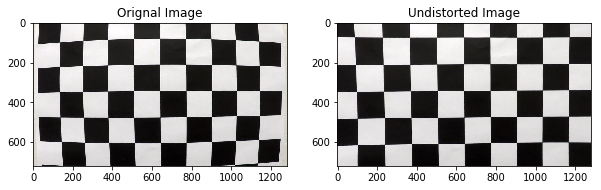

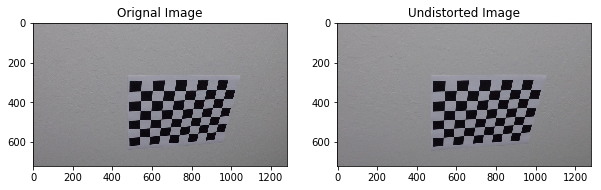

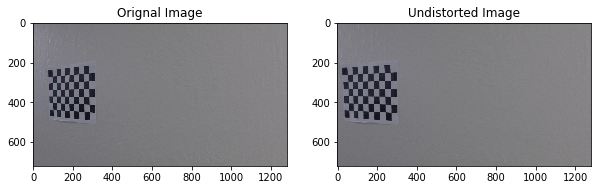

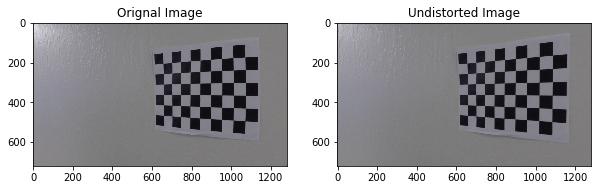

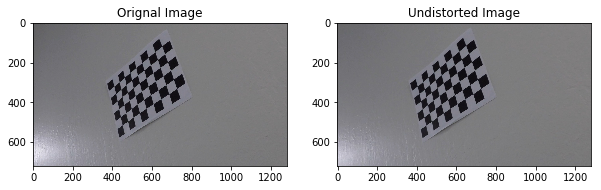

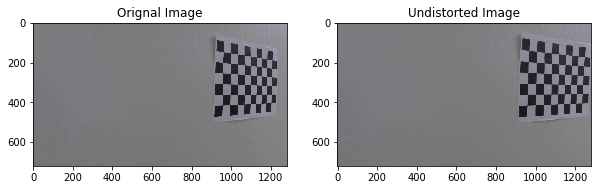

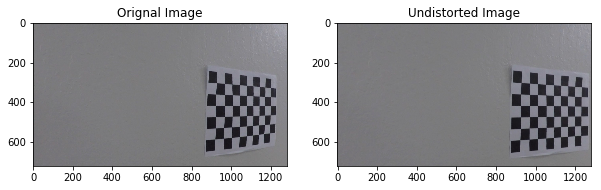

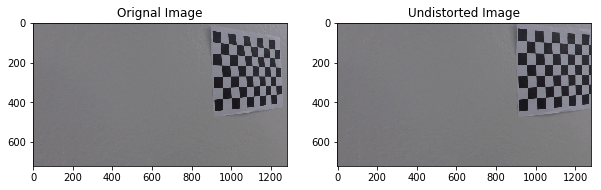

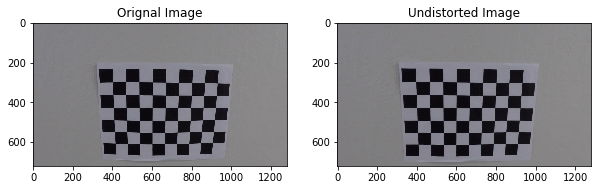

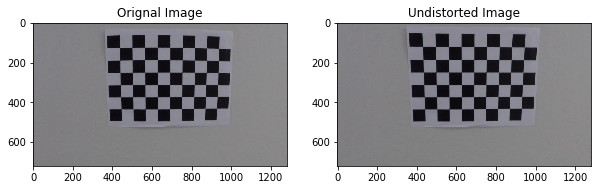

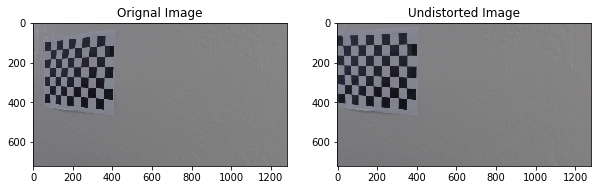

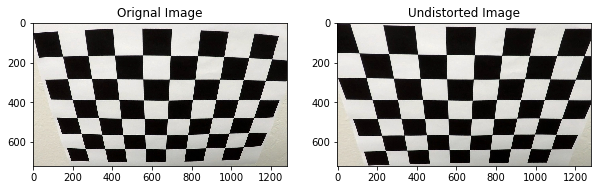

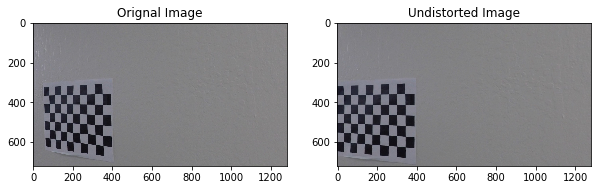

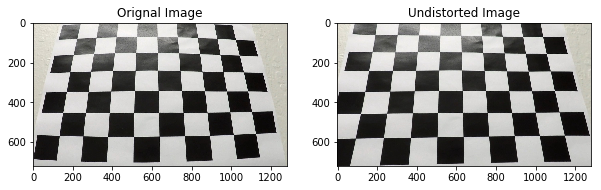

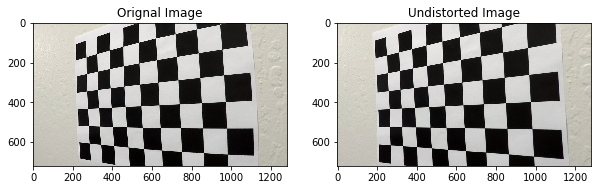

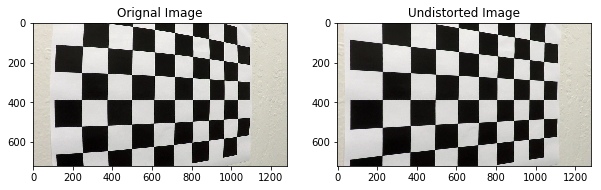

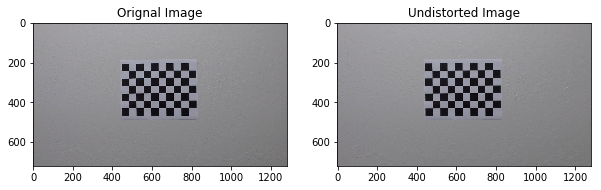

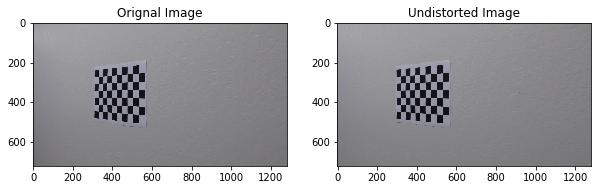

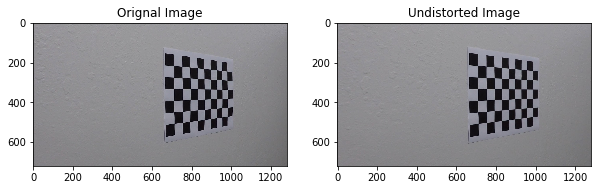

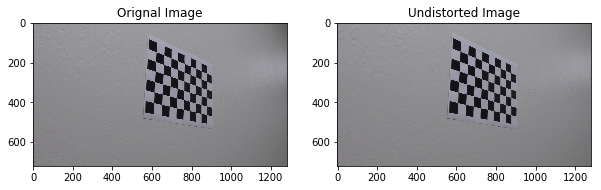

In [4]:
check_camera_calibration = True
i = 0
for path in calibration_images:
    img = mpimg.imread(path)
    i += 1
    if check_camera_calibration:
        save_as = 'output_images/calibration_images/chessboard_images/chessboard_calibration_output_'
        camera_calibrator.plot_calibration_check(img, i, save=False, path=save_as)

### Calibration test

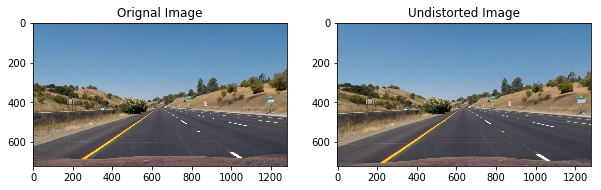

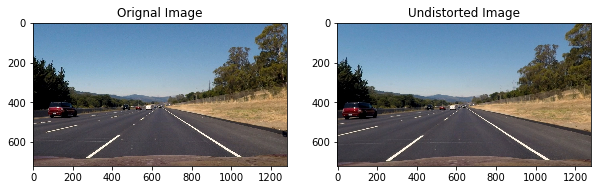

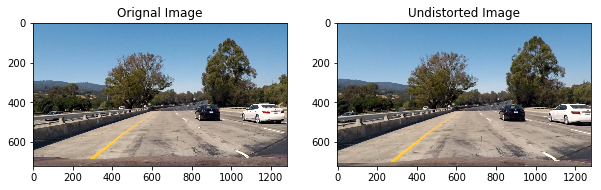

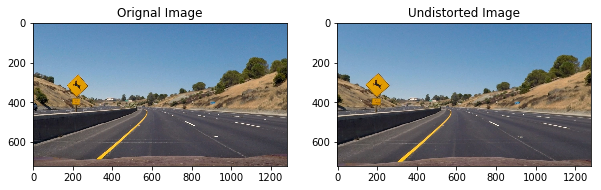

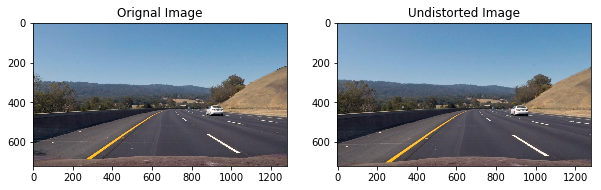

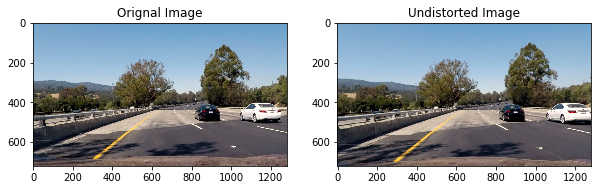

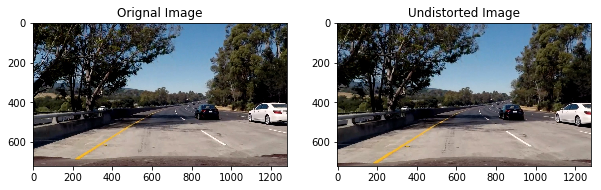

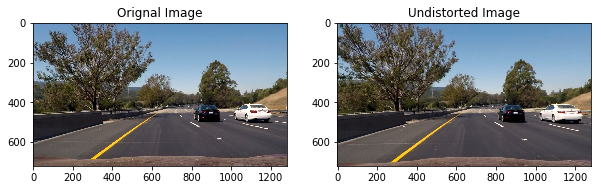

In [5]:
test_camera_calibration = True
test_images = glob.glob('test_images/*')
undistored_images = []
i = 0
for path in test_images:
    img = mpimg.imread(path)
    undistored_images.append(camera_calibrator.undistort_image(img))
    i += 1
    if test_camera_calibration:
        save_as = 'output_images/calibration_images/test_images/tets_calibration_output_'
        camera_calibrator.plot_calibration_check(img, i, save=False, path=save_as)

# Pipeline 

### util methods

In [6]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, np.int32(vertices), ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def convert_to_hsv(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    hsv[:, :, 1] = clahe.apply(hsv[:, :, 1])
    return hsv

def apply_color_threshold(img, thresh=None):
    h = img[:,:,0]
    s = img[:,:,1]
    v = img[:,:,2]
    h_thresh = thresh[0]
    s_thresh = thresh[1]
    v_thresh = thresh[2]
    color_thr_result = np.zeros_like(img[:,:,1])
    color_thr_result[(h >= h_thresh[0]) & (h <= h_thresh[1]) & 
               (s >= s_thresh[0]) & (s <= s_thresh[1]) & 
               (v >= v_thresh[0]) & (v <= v_thresh[1])] = 1
    return color_thr_result

def warp_image(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_imge = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_imge, Minv

def get_color_gradient_combined(grad_combined, color_combined):
    combined = np.zeros_like(grad_combined)
    combined[(grad_combined==1) | (color_combined==1)] = 1
    return combined

In [61]:
class LaneLines():
    def __init__(self, nwindows=9, margin=100, minpix=50, max_nb_acquired_lanes=15):
        self.nwindows = nwindows
        self.margin = margin
        self.minpix = minpix
        self.img_shape = (1280, 720)
        self.full_search_mode = True
        # containers for the x and y positions of nonzero pixels of the image
        self.nonzero = None
        self.nonzeroy = None
        self.nonzerox = None
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.old_lanes = []
        self.max_nb_acquired_lanes = max_nb_acquired_lanes

    def search(self, binary_warped):
        self.current_image = binary_warped
        self.set_search_mode(binary_warped)
        if len(self.old_lanes) >= self.max_nb_acquired_lanes:
            self.old_lanes.pop(0)
        # self.old_lanes.append(copy.copy(self.lane))
        self.old_lanes.append(self)
        self.smooth_fit(binary_warped)

    def set_search_mode(self, binary_warp):
        '''
        Start a full search for lane lines or uses previously knowledge 
        '''
        if self.full_search_mode:
            self.start_full_search(binary_warp)
        else:
            self.fast_search(binary_warp)

    def start_full_search(self, binary_warped):
        self.left_fit = []
        self.right_lane_inds = []
        self.binary_warped = binary_warped
        self.nonzero = binary_warped.nonzero()
        self.nonzeroy = np.array(self.nonzero[0])
        self.nonzerox = np.array(self.nonzero[1])

        histogram = np.sum(self.binary_warped
                           [self.binary_warped.shape[0] // 2:, :], axis=0)
        midpoint = np.int(histogram.shape[0] // 2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        window_height = np.int(self.binary_warped.shape[0] // self.nwindows)
        leftx_current = leftx_base
        rightx_current = rightx_base

        left_lane_inds = []
        right_lane_inds = []
        self.left_lane_inds = []
        self.right_lane_inds = []

        for window in range(self.nwindows):
            win_y_low = self.binary_warped.shape[
                            0] - (window + 1) * window_height
            win_y_high = self.binary_warped.shape[0] - window * window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin

            good_left_inds = ((self.nonzeroy >= win_y_low) &
                              (self.nonzeroy < win_y_high) &
                              (self.nonzerox >= win_xleft_low) &
                              (self.nonzerox < win_xleft_high)).nonzero()[0]

            good_right_inds = ((self.nonzeroy >= win_y_low) &
                               (self.nonzeroy < win_y_high) &
                               (self.nonzerox >= win_xright_low) &
                               (self.nonzerox < win_xright_high)).nonzero()[0]

            # self.left_lane_inds = np.concatenate(good_left_inds)
            # self.right_lane_inds = np.concatenate(good_right_inds)
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(self.nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:
                rightx_current = np.int(
                    np.mean(self.nonzerox[good_right_inds]))

        self.left_lane_inds = np.concatenate(left_lane_inds)
        self.right_lane_inds = np.concatenate(right_lane_inds)

        self.leftx = self.nonzerox[self.left_lane_inds]
        self.lefty = self.nonzeroy[self.left_lane_inds]
        self.rightx = self.nonzerox[self.right_lane_inds]
        self.righty = self.nonzeroy[self.right_lane_inds]

        if len(self.leftx) < 25 or len(self.rightx) < 25:
            # self = self.old
            self.leftx = self.old_leftx
            self.lefty = self.old_lefty
            self.rightx = self.old_rightx
            self.righty = self.old_righty

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        self.fity = np.linspace(0, self.binary_warped.shape[0] - 1, self.binary_warped.shape[0])
        self.fit_leftx = self.left_fit[0] * self.fity ** 2 + self.left_fit[1] * self.fity + self.left_fit[2]
        self.fit_rightx = self.right_fit[0] * self.fity ** 2 + self.right_fit[1] * self.fity + self.right_fit[2]
        self.old_leftx = self.leftx
        self.old_rightx = self.rightx
        self.old_lefty = self.lefty
        self.old_righty = self.righty
        self.exhaustive = False

    def fast_search(self, binary_warped):
        self.binary_warped = binary_warped
        self.nonzero = binary_warped.nonzero()
        self.nonzeroy = np.array(self.nonzero[0])
        self.nonzerox = np.array(self.nonzero[1])
        self.left_lane_inds = ((self.nonzerox > (self.left_fit[0] *
                                                 (self.nonzeroy ** 2) + self.left_fit[1] * self.nonzeroy +
                                                 self.left_fit[2] - self.margin)) &
                               (self.nonzerox < (self.left_fit[0] * (self.nonzeroy ** 2) +
                                                 self.left_fit[1] * self.nonzeroy +
                                                 self.left_fit[2] + self.margin)))

        self.right_lane_inds = ((self.nonzerox > (self.right_fit[0] *
                                                  (self.nonzeroy ** 2) + self.right_fit[1] * self.nonzeroy +
                                                  self.right_fit[2] - self.margin)) & (self.nonzerox <
                                                                                       (self.right_fit[0] * (
                                                                                       self.nonzeroy ** 2) +
                                                                                        self.right_fit[1] *
                                                                                        self.nonzeroy + self.right_fit[
                                                                                            2] + self.margin)))

        self.leftx = self.nonzerox[self.left_lane_inds]
        self.lefty = self.nonzeroy[self.left_lane_inds]
        self.rightx = self.nonzerox[self.right_lane_inds]
        self.righty = self.nonzeroy[self.right_lane_inds]

        if len(self.leftx) < 25 or len(self.rightx) < 25:
            self.exhaustive_search(binary_warped)

        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)

        self.fity = np.linspace(0, self.binary_warped.shape[0] - 1, self.binary_warped.shape[0])
        self.fit_leftx = self.left_fit[0] * self.fity ** 2 + self.left_fit[1] * self.fity + self.left_fit[2]
        self.fit_rightx = self.right_fit[0] * self.fity ** 2 + self.right_fit[1] * self.fity + self.right_fit[2]

    def plot(self):
        out_img = np.dstack(
            (self.binary_warped, self.binary_warped, self.binary_warped)) * 255
        window_img = np.zeros_like(out_img)
        out_img[self.nonzeroy[self.left_lane_inds],
                self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds],
                self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        left_line_window1 = np.array(
            [np.transpose(np.vstack([self.fit_leftx - self.margin, self.fity]))])
        left_line_window2 = np.array(
            [np.flipud(np.transpose(np.vstack([self.fit_leftx + self.margin, self.fity])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array(
            [np.transpose(np.vstack([self.fit_rightx - self.margin, self.fity]))])
        right_line_window2 = np.array(
            [np.flipud(np.transpose(np.vstack([self.fit_rightx + self.margin, self.fity])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        return result, self.fit_leftx, self.fit_rightx, self.fity

    #         plt.imshow(result)
    #         plt.plot(self.fit_leftx, self.fity, color='yellow', linewidth=5.0)
    #         plt.plot(self.fit_rightx, self.fity, color='yellow', linewidth=5.0)
    #         plt.xlim(0, 1280)
    #         plt.ylim(720, 0)

    def smooth_fit(self, binary_warped):
        self.current_image = binary_warped
        leftx, lefty = [], []
        rightx, righty = [], []

        for i, lane in enumerate(self.old_lanes):
            leftx.extend(lane.leftx)
            lefty.extend(lane.lefty)
            rightx.extend(lane.rightx)
            righty.extend(lane.righty)
        leftx = np.array(leftx)
        rightx = np.array(rightx)
        lefty = np.array(lefty)
        righty = np.array(righty)
        self.leftx, self.lefty = leftx, lefty
        self.rightx, self.righty = rightx, righty
        self.fity = np.linspace(0, self.current_image.shape[0] - 1, self.current_image.shape[0])
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        self.fit_leftx = np.array(self.left_fit[0] * self.fity ** 2 + self.left_fit[1] * self.fity + self.left_fit[2])
        self.fit_rightx = np.array(
            self.right_fit[0] * self.fity ** 2 + self.right_fit[1] * self.fity + self.right_fit[2])
        self._set_variables(leftx, rightx, lefty, righty, self.left_fit, self.right_fit, self.fit_leftx,
                            self.fit_rightx)

    def _set_variables(self, leftx, rightx, lefty, righty, left_fit, right_fit, fit_leftx, fit_rightx):
        self.leftx, self.lefty = leftx, lefty
        self.rightx, self.righty = rightx, righty
        self.left_fit, self.right_fit = left_fit, right_fit
        self.fit_leftx, self.fit_rightx = fit_leftx, fit_rightx

    def calculate_curvature(self, real=False):
        # Around middle of the image, I think it will give use better
        # results since we can get better value from perspective
        # transform
        y_eval = 360
        ploty = np.linspace(0, 719, num=720)
        quadratic_coeff = 3e-4  # arbitrary quadratic coefficient

        if real:
            ym_per_pix = 30 / 720
            xm_per_pix = 3.7 / 700

            left_fit_cr = np.polyfit(self.lefty * ym_per_pix,
                                     self.leftx * xm_per_pix, 2)
            right_fit_cr = np.polyfit(self.righty * ym_per_pix,
                                      self.rightx * xm_per_pix, 2)

        else:
            left_fit_cr = self.left_fit
            right_fit_cr = self.right_fit
            # right_curverad = self.right_fit
            ym_per_pix = 1.0
            xm_per_pix = 1.0

        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix +
                               left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix +
                                right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])

        return left_curverad, right_curverad

    def translate_to_real_world_image(self, image, Minv):
        warped = self.binary_warped
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        pts_left = np.array([np.transpose(
            np.vstack([self.fit_leftx, self.fity]))])
        pts_right = np.array([np.flipud(np.transpose(
            np.vstack([self.fit_rightx, self.fity])))])

        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        newwarp = cv2.warpPerspective(color_warp, Minv, self.img_shape)
        # image = cv2.warpPerspective(image, Minv, self.img_shape)
        left_curvature, right_curvature = self.calculate_curvature(real=True)

        cv2.putText(image, "Curvature: " + str(int(left_curvature)) + ' (m)',
                    (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), thickness=3)
        cv2.putText(image, str("%.2f" % self.calculate_relative_position()),
                    (100, 170), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), thickness=3)

        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        return result

    def calculate_relative_position(self, xm_per_pix=3.7 / 700):
        middle = 360
        left = self.calculate_val(self.left_fit, middle)
        right = self.calculate_val(self.right_fit, middle)
        car_middle_pixel = int((left + right) / 2)
        screen_off_center = middle - car_middle_pixel
        return xm_per_pix * screen_off_center

    def calculate_val(self, fit, val):
        return fit[0] * val ** 2 + fit[1] * val + fit[2]

In [62]:
from gradient_threshold import GradientThreshold
#from lane_lines import LaneLines

gradient_threshold = GradientThreshold(kernel=3, thres_x=(20, 200), thres_y=(45, 150), 
                                       thres_mag=(35, 255), thres_dir=(0.7, 1.3))
lane = LaneLines()

In [74]:
src      =  np.array([[205, 720], [1180, 720], [780, 480], [555, 480]], np.float32)
vertices = [np.array([[205, 720], [1180, 720], [780, 480], [555, 480]], np.int32)]
dst = np.array([[205, 720], [1120, 720], [1120, 0], [205, 0]], np.float32)

first_color_thresh=([[18,31], [60,255], [90,255]])
second_color_thresh=([[0,57], [90,255], [180,255]])

In [75]:
def video_pipeline(img, test=False):
    # undistort the image
    undistored_image = camera_calibrator.undistort_image(img)
    # apply gradient threshold
    gt_result = gradient_threshold.get_gradient_threshold_combined(undistored_image)
    # apply color threshold
    hsv = convert_to_hsv(undistored_image)
    ct_result_1 = apply_color_threshold(hsv, first_color_thresh)
    ct_result_2 = apply_color_threshold(hsv, second_color_thresh)
    ct_result = ct_result_1 & ct_result_2
    # combine gradient and color threshold
#     combined_image = get_color_gradient_combined(gt_result, ct_result)
    # mask the image
    masked_image = region_of_interest(combined_image, vertices)
    # warp the image
    binary_warped, Minv = warp_image(masked_image, src, dst)
    # Find the lane lines
    lane.search(binary_warped)
    lane_lines = lane.translate_to_real_world_image(undistored_image, Minv)
    if test:
        return combined_image, gt_result, ct_result, masked_image, binary_warped, lane, lane_lines
    else: 
        return lane_lines

### Pipeline test

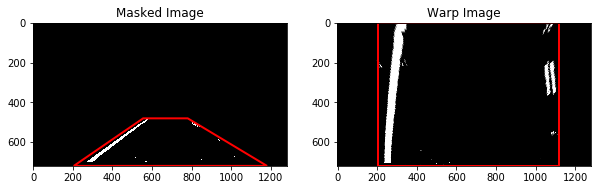

In [80]:
plot_pipeline_test = True
save_resutls = False
img_index = 7 # must be <= 7

def plot_test_result(test_image, gt_results, ct_results, masked_images, warp, lane, pipeline_results):
    plt.close('all')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    ax1.set_title('Masked Image')
    ax1.imshow(masked_images, cmap='gray')
    rect = patches.Polygon(src, closed=True, fill=False, edgecolor='r', linewidth=2)
    ax1.add_patch(rect)
    ax2.set_title('Warp Image')
    stack_image = np.dstack(( np.zeros_like(gt_results), gt_results, ct_results))
    ax2.imshow(warp, cmap='gray')
    rect = patches.Polygon(dst, closed=True, fill=False, edgecolor='r', linewidth=2)
    ax2.add_patch(rect)
    plt.savefig('output_images/pipeline_result_images/warp_image.jpg')
    
#     plt.close('all')
#     fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
#     img = mpimg.imread(test_image)
#     ax1.set_title('Original Image')
#     ax1.imshow(img)
#     stack_image = np.dstack(( np.zeros_like(gt_results), gt_results, ct_results))
#     ax2.set_title('Gradient + Color thresholded Image')
#     ax2.imshow(stack_image)
#     rect = patches.Polygon(src, closed=True, fill=False, edgecolor='r', linewidth=2)
#     ax2.add_patch(rect)
#     ax3.set_title('Masked Image')
#     ax3.imshow(masked_images, cmap='gray')
#     rect = patches.Polygon(src, closed=True, fill=False, edgecolor='r', linewidth=2)
#     ax3.add_patch(rect)
#     if save_resutls:
#         plt.savefig('output_images/pipeline_result_images/pipeline_result_1.jpg')
#     fig2, ((ax4, ax5, ax6)) = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
#     ax4.set_title('Warp Image')
#     ax4.imshow(warp, cmap='gray')
#     rect = patches.Polygon(dst, closed=True, fill=False, edgecolor='r', linewidth=2)
#     ax4.add_patch(rect)
#     result, fit_leftx, fit_rightx, fity = lane.plot()
#     ax5.set_title('Lane Lines')
#     ax5.imshow(result)
#     ax5.plot(fit_leftx, fity, color='yellow', linewidth=5.0)
#     ax5.plot(fit_rightx, fity, color='yellow', linewidth=5.0)
#     ax6.set_title('Pipeline Result')
#     ax6.imshow(pipeline_results)
#     if save_resutls:
#         plt.savefig('output_images/pipeline_result_images/pipeline_result_2.jpg')
    
        
def test_video_pipeline():
    combined_images = []
    gt_results = [] 
    ct_results = []
    masked_images = []
    warps = []
    lanes = []
    pipeline_results = []
    for path in test_images:
        img = mpimg.imread(path)
        combined_image, gt_result, ct_result, masked_image, warped, lane, lane_lines = video_pipeline(img, True)
        combined_images.append(combined_image)
        gt_results.append(gt_result)
        ct_results.append(ct_result)
        masked_images.append(masked_image)
        warps.append(warped)
        lanes.append(lane)
        pipeline_results.append(lane_lines)
    plot_test_result(test_images[img_index], gt_results[img_index], ct_results[img_index], 
                      masked_images[img_index], warps[img_index], lanes[img_index], pipeline_results[img_index])
    
if plot_pipeline_test:
    test_video_pipeline()

# Process video

In [67]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

In [68]:
def process_video(image):
    result = video_pipeline(image)
    return result

In [ ]:
video_output = 'output_video/project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')

clip = clip1.fl_image(process_video)
%time clip.write_videofile(video_output, audio=False)

In [ ]:
video_output = 'output_video/challenge_video_output.mp4'
clip1 = VideoFileClip('challenge_video.mp4')

clip = clip1.fl_image(process_video)
%time clip.write_videofile(video_output, audio=False)

In [ ]:
video_output = 'output_video/harder_challenge_video_output.mp4'
clip1 = VideoFileClip('harder_challenge_video.mp4')

clip = clip1.fl_image(process_video)
%time clip.write_videofile(video_output, audio=False)